In [27]:
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import col,sum
from pyspark.sql.functions import from_utc_timestamp
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import from_unixtime
from pyspark.sql.types import DateType
from pyspark.sql.functions import split
from pyspark.sql import Window

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
spark = SparkSession \
    .builder \
    .appName("Sparkify_project") \
    .getOrCreate()

In [29]:
spark

In [30]:
def load_data(filename):
    
    '''
    Funtion to load data and remove null, empty strings.
    INPUT
    filename = name of file as well the path
    OUTPUT
    df - a spark dataframe with no null rows for primary key
    '''
    
    df = spark.read.json(filename)
    
    
    print('\n Data Set loaded Succesfully')
    print("\n Count of rows in dataframe: {}".format(df.count()))
    
    return df
    

In [31]:
path = "mini_sparkify_event_data.json"
df = load_data(path)


 Data Set loaded Succesfully

 Count of rows in dataframe: 286500


In [32]:
print(df.printSchema())

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

None


In [33]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [34]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|            228108|286500|           278154|286500| 286500|     

In [35]:
df.count()

286500

## Removing the Missing values

In [36]:
def remove_na(df):
    
    print("Removing the NA Values in the dataset ")
    print("-"*115)
    print("\n The size of the Data set before removing NA:",df.count())
    
    df = df.dropna(how = "any", subset = ["userId", "sessionId"])
    df = df.filter(df["userId"] != "")
    
    print("\n The size of the Data set after removing NA:",df.count())
    
    print("\n Updated Table after removing the NA Values ")
    print("-"*115)
    
    df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns)).show() 
    print("-"*115)
    
    return df

In [37]:
df = remove_na(df)

Removing the NA Values in the dataset 
-------------------------------------------------------------------------------------------------------------------

 The size of the Data set before removing NA: 286500

 The size of the Data set after removing NA: 278154

 Updated Table after removing the NA Values 
-------------------------------------------------------------------------------------------------------------------
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|    

## Some Basic Explorations

In [38]:
def add_date_columns(df):
    '''
    Funtion to add date/time related columns to the dataframe.
    INPUT - a spark dataframe
    OUPUT - a spark dataframe with calculated fields: hour, month, year, day
    '''
    # create a function to get hour, month, year, day from timestamp
    get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
    get_month = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).month)
    get_year = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).year)
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
    
    
    # add hour, month, year, day, date columns to the dataframe
    df = df.withColumn("hour", get_hour(df.ts))
    df = df.withColumn("month", get_month(df.ts))
    df = df.withColumn("year", get_year(df.ts))
    df = df.withColumn("day", get_day(df.ts))
    df = df.withColumn("date", from_unixtime(df.ts/1000).cast(DateType()))
    
    #df_test2.withColumn('date_again', func.from_unixtime('timestamp').cast(DateType()))
    
    
    return df

In [39]:
df = add_date_columns(df)

In [40]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='2', month='10', year='2018', day='1', date=datetime.date(2018, 10, 1))

In [41]:
print(df.printSchema())

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- day: string (nullable = true)
 |-- date: date (nullable = true)

None


In [42]:
def get_hour_stats(df):
    
    '''
    Funtion to load data and plot the scatter plot for hour by hour stats.
    INPUT
    filename = df - a spark dataframe
    OUTPUT
    df - a scatter plot from matplotlib
    '''
    
    songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))
    songs_in_hour_pd = songs_in_hour.toPandas()
    songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)
    
    
    plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
    plt.xlim(-1, 24);
    plt.ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
    plt.xlabel("Hour")
    plt.ylabel("Songs played");

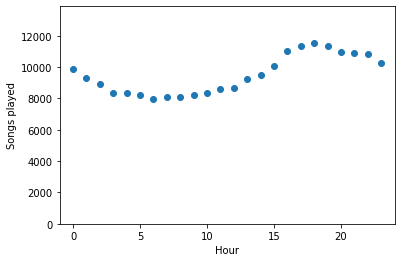

In [43]:
get_hour_stats(df)

In [44]:
unique_users = df.select('userId','level','gender','location').distinct()

print("\n The Number of Unique Users in the Data Set is:",unique_users.count())


 The Number of Unique Users in the Data Set is: 360


In [45]:
def plot_gender_stats(data):
    
    '''
    Funtion to load data and plot the bar plot for user gender stats.
    
    INPUT
    filename = df - a spark dataframe
    OUTPUT
    df - a bar plot from matplotlib
    '''
    
    gender_count = df.groupby('gender').count().toPandas()
    gender_count.set_index('gender',inplace = True)
    gender_count
    
    
    gender_count.plot(kind='bar',figsize=(10,5))
    plt.title('Gender Comparison',fontsize = 15)
    plt.ylabel('Count',fontsize = 15)
    plt.xlabel('Gender',fontsize = 15)
    plt.xticks(fontsize = 15,rotation = 45);
    
    
def plot_level_stats(data):
    
    '''
    Funtion to load data and plot the bar plot for user level stats.
    
    INPUT
    filename = df - a spark dataframe
    OUTPUT
    df - a bar plot from matplotlib
    '''
    
    unique_users_level = df.groupby('level').count().toPandas()
    unique_users_level.set_index('level',inplace = True)
    unique_users_level
    
    unique_users_level.plot(kind='bar',figsize=(10,5))
    plt.title('Account Type comparison',fontsize = 15)
    plt.ylabel('Count',fontsize = 15)
    plt.xlabel('Account type',fontsize = 15)
    plt.xticks(fontsize = 15,rotation = 45);
    
def most_played_artist(data):
    
    '''
    Funtion to load data and plot the bar plot for most played stats.
    
    INPUT
    filename = df - a spark dataframe
    OUTPUT
    df - a bar plot from matplotlib
    '''
    
    most_played_artist = df.filter(df.page == 'NextSong').select('Artist').groupBy('Artist').count().toPandas()
    most_played_artist = most_played_artist.sort_values(by=['count'],ascending = False).head(10)
    
    sns.barplot('Artist', 'count', data= most_played_artist)
    plt.title('Top 10 Artists')
    plt.xticks(rotation = 90);
    
def most_played_song(data):
    
    
    '''
    Funtion to load data and plot the bar plot for most played stats.
    
    INPUT
    filename = df - a spark dataframe
    OUTPUT
    df - a bar plot from matplotlib
    '''
    
    most_played_song = df.filter(df.page == 'NextSong').select('song').groupBy('song').count().toPandas()
    most_played_song = most_played_song.sort_values(by=['count'],ascending = False).head(10)
    
    sns.barplot('song', 'count', data= most_played_song)
    plt.title('Top 10 songs')
    plt.xticks(rotation = 90); 

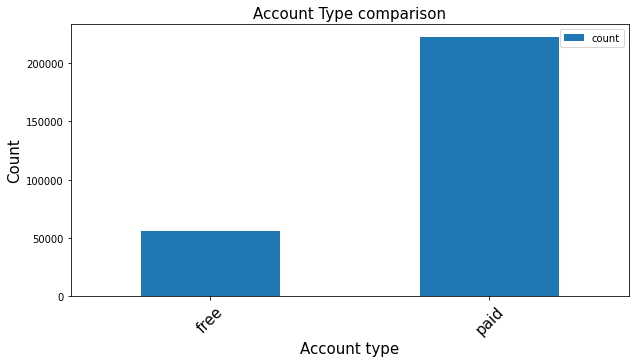

In [46]:
plot_level_stats(df)

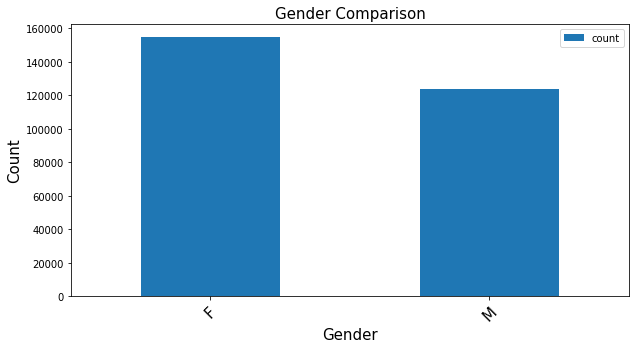

In [47]:
plot_gender_stats(df)

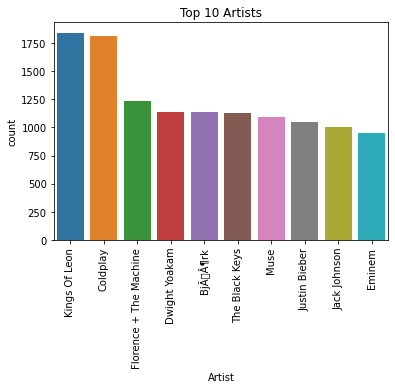

In [48]:
most_played_artist(df)

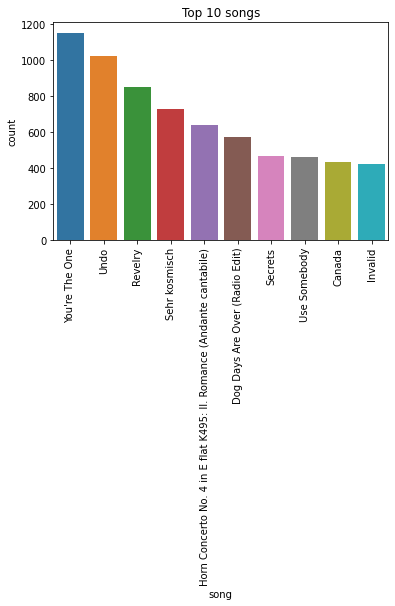

In [49]:
most_played_song(df)

In [50]:
churn_flag = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('isChurn', churn_flag('page'))

In [52]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("isChurn", Fsum("isChurn").over(windowval))

In [54]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [60]:
df.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', hour='19', month='11', year='2018', day='21', date=datetime.date(2018, 11, 21), isChurn=0)

### Churn Distribution

In [70]:
churn_distribution = df.groupby('isChurn').count().toPandas()

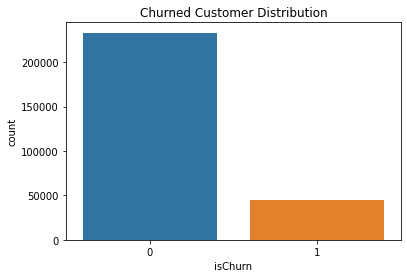

In [72]:
sns.barplot('isChurn', 'count', data= churn_distribution)
plt.title('Churned Customer Distribution');

### Average Skipped Songs

In [81]:
skipped_songs = df.filter(df['page'] == 'NextSong').groupby('isChurn').agg({"userId": "avg"}).withColumnRenamed("avg(userId)", "avgskippedsongs").toPandas()
skipped_songs

,isChurn,avgskippedsongs
0,0,58497.226754
1,1,58592.305078


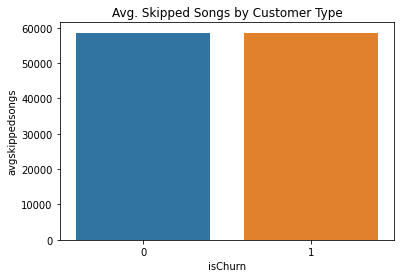

In [83]:
sns.barplot('isChurn', 'avgskippedsongs', data= skipped_songs)
plt.title('Avg. Skipped Songs by Customer Type');

### Avg thumbs up

In [88]:
avg_thumbs_up = df.filter(df['page'] == 'Thumbs Up')\
.groupby('isChurn')\
.agg({"userId": "avg"})\
.withColumnRenamed("avg(userId)", "avgthumbsup").toPandas()

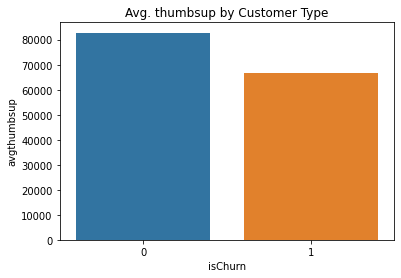

In [89]:
sns.barplot('isChurn', 'avgthumbsup', data= avg_thumbs_up)
plt.title('Avg. thumbsup by Customer Type');

### Avg thumbs down

In [94]:
avg_thumbs_down = df.filter(df['page'] == 'Thumbs Down')\
.groupby('isChurn')\
.agg({"userId": "avg"})\
.withColumnRenamed("avg(userId)", "avgthumbsdown").toPandas()

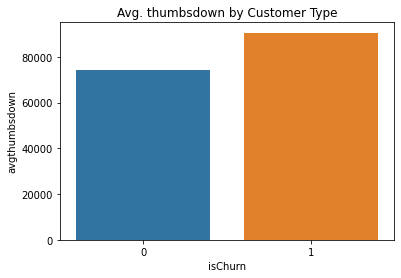

In [95]:
sns.barplot('isChurn', 'avgthumbsdown', data= avg_thumbs_down)
plt.title('Avg. thumbsdown by Customer Type');

## Feature Extraction

In [108]:
def get_flag_churn(df):
    '''
    Funtion to add churn flag that identifies whether a user has churned.
    INPUT - a spark dataframe
    OUPUT - a spark dataframe with userId of each user, churn flag and gender
    '''
    
    # function to flag 'cancellation confirmation' event
    flag_cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    df = df.withColumn("churn", flag_cancel_event("page"))
    user_churn = df.groupBy("userId").agg({"churn":"max", "gender":"max"})\
                           .withColumnRenamed("max(churn)", "label")\
                           .withColumnRenamed("max(gender)", "gender")
    
    #print("Count of rows: {}".format(user_churn.count()))
    return user_churn

In [110]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- hour: string (nullable = true)
 |-- month: string (nullable = true)
 |-- year: string (nullable = true)
 |-- day: string (nullable = true)
 |-- date: date (nullable = true)
 |-- isChurn: long (nullable = true)



In [113]:
def get_latest_level(df):
    '''
    Funtion to find the latest level of each user.
    INPUT - a spark dataframe
    OUPUT - a spark dataframe with userId of each user and latest level
    '''
    # use timestamp to identify the most latest record for a user
    # sort timestamp in descending order and than drop duplicates to get the last row for each user
    latest_level = df.select(["userId", "level", "ts"])\
                        .orderBy(desc("ts"))\
                        .dropDuplicates(["userId"])\
                        .select(["userId", "level"])
    #print("Count of rows: {}".format(latest_level.count()))
    return latest_level